In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)

In [2]:
img_paths=[]
img_labels=[]
for i in glob('../input/satellite-images-of-hurricane-damage/**',recursive=True):
    if i.endswith('.jpeg'):
        a=i.split('/')
        img_paths.append(i)
        img_labels.append(a[-2])

In [3]:
len(img_paths),len(img_labels)

(23000, 23000)

In [4]:
img_path = pd.Series(img_paths).astype(str)
labels=pd.Series(img_labels)
data = pd.concat([img_path,labels],axis=1)
data.sample(5)

,0,1
16363,../input/satellite-images-of-hurricane-damage/test_another/damage/-95.612723_29.765194.jpeg,damage
7694,../input/satellite-images-of-hurricane-damage/train_another/no_damage/-95.630318_29.769136.jpeg,no_damage
10139,../input/satellite-images-of-hurricane-damage/test_another/damage/-93.788062_30.129061.jpeg,damage
10280,../input/satellite-images-of-hurricane-damage/test_another/damage/-95.640945_29.840747999999998.jpeg,damage
3987,../input/satellite-images-of-hurricane-damage/train_another/damage/-95.632386_29.84732.jpeg,damage


In [5]:
from sklearn.model_selection import train_test_split
train_set , test_set = train_test_split(data,test_size=0.25,random_state=0)
train_set.shape,test_set.shape

((17250, 2), (5750, 2))

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

In [7]:
train_gen = ImageDataGenerator(validation_split=0.1,rotation_range=10, 
        width_shift_range=0.2, 
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True, 
        brightness_range=[0.2,1.2]) 
test_gen = ImageDataGenerator(rotation_range=10, 
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True, 
        brightness_range=[0.2,1.2]) 

train_data = train_gen.flow_from_dataframe(
    dataframe = train_set,
    x_col = 0,
    y_col = 1,
    target_size = (227,227),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training',
    batch_size=100,
    seed=2020
)

val_data = train_gen.flow_from_dataframe(
    dataframe = train_set,
    x_col = 0,
    y_col = 1,
    target_size = (227,227),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False,
    subset = 'validation',
    batch_size=100,
    seed=2020
)

test_data = test_gen.flow_from_dataframe(
    dataframe = test_set,
    x_col = 0,
    y_col = 1,
    target_size = (227,227),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False,
    batch_size=100,
    seed=2020
)

Found 15525 validated image filenames belonging to 2 classes.
Found 1725 validated image filenames belonging to 2 classes.
Found 5750 validated image filenames belonging to 2 classes.


In [8]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    
    
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='sigmoid')
])
model.compile(
    optimizer=tf.optimizers.Adam(lr=0.000001),
    loss='binary_crossentropy',
    metrics=['accuracy','Recall']
)


In [9]:
!pip install wandb --upgrade
import wandb
from wandb.keras import WandbCallback
wandb.login(key = '5c890c5f71b46a63dd49c1b634505dc3159a874b')
wandb.init(project="ML_J_COMP_TENSORFLOW")

     |████████████████████████████████| 1.8 MB 926 kB/s 
  Attempting uninstall: wandb
    Found existing installation: wandb 0.10.33
    Uninstalling wandb-0.10.33:
      Successfully uninstalled wandb-0.10.33
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.5.0 requires wandb<0.11.0,>=0.10.0, but you have wandb 0.12.12 which is incompatible.


wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gthejin (use `wandb login --relogin` to force relogin)


In [10]:
history = model.fit(train_data,epochs=15,validation_data=val_data,callbacks = [WandbCallback()])

Epoch 1/15
156/156 [==============================] - 284s 2s/step - loss: 1.2234 - accuracy: 0.5649 - recall: 0.5270 - val_loss: 0.5952 - val_accuracy: 0.6812 - val_recall: 0.6730
Epoch 2/15
156/156 [==============================] - 234s 2s/step - loss: 0.9430 - accuracy: 0.6843 - recall: 0.6495 - val_loss: 0.5524 - val_accuracy: 0.7159 - val_recall: 0.7432
Epoch 3/15
156/156 [==============================] - 235s 2s/step - loss: 0.8289 - accuracy: 0.7143 - recall: 0.6885 - val_loss: 0.4977 - val_accuracy: 0.7693 - val_recall: 0.7977
Epoch 4/15
156/156 [==============================] - 234s 2s/step - loss: 0.7827 - accuracy: 0.7397 - recall: 0.7098 - val_loss: 0.4837 - val_accuracy: 0.7855 - val_recall: 0.7983
Epoch 5/15
156/156 [==============================] - 237s 2s/step - loss: 0.7116 - accuracy: 0.7609 - recall: 0.7264 - val_loss: 0.4576 - val_accuracy: 0.8145 - val_recall: 0.8336
Epoch 6/15
156/156 [==============================] - 234s 2s/step - loss: 0.6625 - accuracy: 0

In [11]:
y_pred = model.predict(test_data)
y_pred = np.argmax(y_pred,axis=1)

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_data.labels,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      3739
           1       0.88      0.79      0.83      2011

    accuracy                           0.89      5750
   macro avg       0.89      0.87      0.88      5750
weighted avg       0.89      0.89      0.89      5750



In [13]:
classes=['Damage','No Damage']
con_mat_df = pd.DataFrame(confusion_matrix(test_data.labels,y_pred),
                     index = classes, 
                     columns = classes)

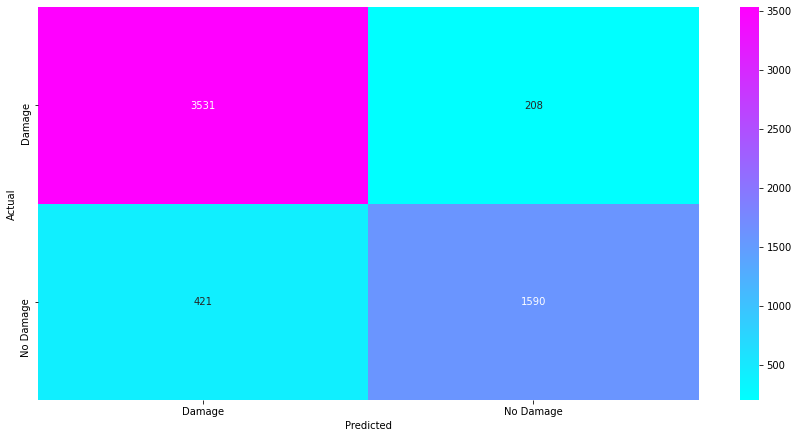

In [14]:
import seaborn as sns
figure = plt.figure(figsize=(12, 6))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.cool,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()